In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from prettytable import PrettyTable
from scipy.fft import fftshift, ifftshift, fft, ifft

import hpcom
from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter
from hpcom.channel import create_channel_parameters

# from ssfm_gpu.propagation import propagate_manakov, dispersion_compensation_manakov
from ssfm_gpu.propagation import propagate_schrodinger, dispersion_compensation
from ssfm_gpu.conversion import convert_forward, convert_inverse

# from signal_handling.processing import get_process_parameters, get_default_process_parameters, get_windowed_signal
import signal_handling.processing as prcs

import tools.functions as fn

reload(prcs)
reload(hpcom)

from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter

2023-05-15 18:30:31.045597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
# Function to format x-ticks as 2 in power something
def format_ticks(x, pos):
    return f'$10^{{{int(np.log10(x))}}}$'

# Define a custom tick formatter function
def custom_sci_notation(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exponent
    return r"${:.1f} \times 10^{{{}}}$".format(coeff, exponent)


Allocate GPU memory to limit its usage

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-15 18:30:34.891951: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-15 18:30:34.894448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-15 18:30:34.965452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 18:30:34.965829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-05-15 18:30:34.965862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-15 18:30:34.978758: I tensorflow/stream_executor/p

Create WDM signal
- one polarisation (NLSE)
- 16-QAM
- 0 dBm average power
and channel parameters
- lossless
- no noise

In [27]:
wdm = create_wdm_parameters(n_channels=1, p_ave_dbm=3, n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=4,
                            downsampling_rate=1, symb_freq=100e9, channel_spacing=100e9, n_polarisations=1, seed='fixed')

channel = create_channel_parameters(n_spans=12,
                                    z_span=80,
                                    alpha_db=0.0,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

name_set = fn.form_name(wdm, channel)
print(name_set)

_16qam_100gbd_12spans_80km


In [35]:
signal_x, wdm_info = generate_wdm(wdm)
points_x_orig = wdm_info['points_x'][0]  # [0] index for only one WDM channel

ft_filter_values = wdm_info['ft_filter_values_x'][0]  # [0] index for only one WDM channel
# points_x_wo_prop = get_points_wdm(receiver_wdm(signal_x, ft_filter_values, wdm)[0], wdm)

p_ave_filt = np.mean(np.power(np.absolute(ft_filter_values), 2))
print(p_ave_filt, wdm['upsampling'])
# ft_filter_values *= np.sqrt(wdm['upsampling'] / p_ave_filt)
# ft_filter_values *= np.sqrt(1 / p_ave_filt)
ft_filter_values *= 1 / p_ave_filt
print(np.mean(np.power(np.absolute(ft_filter_values), 2)))

# points_x_wo_prop = get_points_wdm(hpcom.signal.matched_filter(signal_x, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
points_x_wo_prop = get_points_wdm(hpcom.signal.filter_shaper(signal_x, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
scale_p = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_wo_prop)

# start_time = datetime.now()
# signal_x = propagate_schrodinger(channel, signal_x, wdm['sample_freq'])
# print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

print(scale_p)

3.9999999999999756 4
0.2500000000000016
(1.0000000000083231-2.7070339373150296e-16j)


In [33]:
np.max(np.absolute(points_x_wo_prop - points_x_orig))

1.7286212892391398e-10

In [19]:
print(1. / wdm['sample_freq'])
print(1. / wdm['symb_freq'])
print(len(signal_x) / scale_p, scale_p/len(signal_x))

1.25e-12
1e-11
(7.78722228179872+1.7942980135715776e-15j) (0.1284154944873381-2.958894177311456e-17j)


In [460]:
dt_dim = 1. / wdm['sample_freq']
t_dim = np.arange(len(signal_x)) * dt_dim

convert_result = convert_inverse(signal_x, t_dim, channel['z_span'],
                                 channel['beta2'],
                                 channel['gamma'],
                                 t0=1. / wdm['symb_freq'], type='nlse')

q = convert_result['q']
t = convert_result['t']
dt = t[0] - t[1]
z_span_dimless = convert_result['z']
print(f'{channel["z_span"]} x {channel["n_spans"]} = {channel["z_span"] * channel["n_spans"]} km \n',
      f'{z_span_dimless} x {channel["n_spans"]} = {z_span_dimless * channel["n_spans"]}')

channel_dimensionless = channel.copy()
channel_dimensionless['beta2'] = -1.
channel_dimensionless['gamma'] = 1.
channel_dimensionless['z_span'] = z_span_dimless
# channel_dimensionless['nz'] = 800

start_time = datetime.now()
signal_prop = propagate_schrodinger(channel, signal_x, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

start_time = datetime.now()
q_prop = propagate_schrodinger(channel_dimensionless, q, sample_freq=1./dt)
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

convert_forward_result = convert_forward(q_prop, t, channel_dimensionless['z_span'],
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='nlse')

signal_from_q_prop = convert_forward_result['Q']

80 x 12 = 960 km 
 17.130164834866882 x 12 = 205.56197801840258
propagation took 1118.483 ms
propagation took 1477.05 ms


(0.0, 5.12e-09)

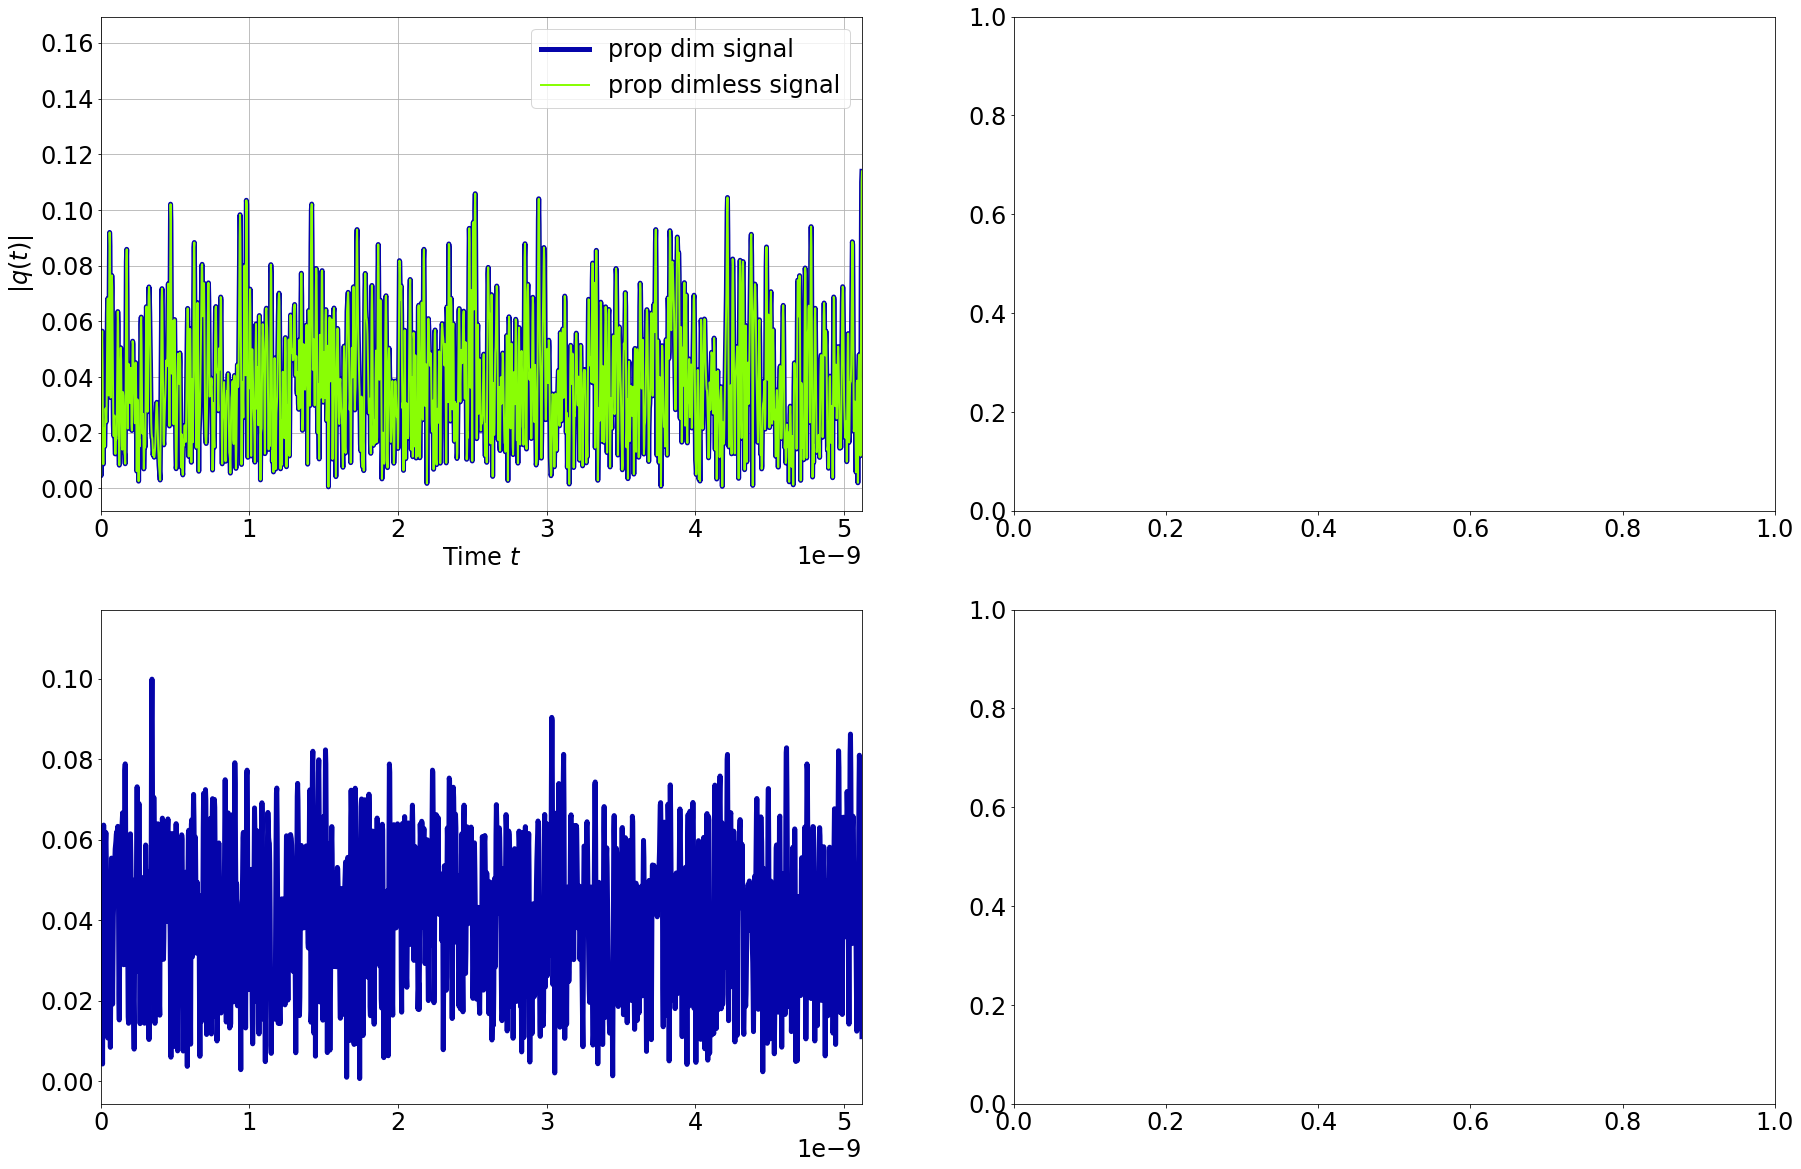

In [461]:
fig, axs = plt.subplots(2, 2, figsize=(30,20))
axs[0][0].plot(t_dim, np.absolute(signal_prop),
               color='xkcd:royal blue', linewidth=5,
               label='prop dim signal')
axs[0][0].plot(t_dim, np.absolute(signal_from_q_prop),
               color='xkcd:lime green', linewidth=2,
               label='prop dimless signal')
axs[0][0].set_xlabel('Time $t$')
axs[0][0].set_xlim(t_dim[0], t_dim[2048])
# axs[0][0].set_xlim(-t_plot_full_lim, t_plot_full_lim)
axs[0][0].set_ylabel(r'$|q(t)|$')
axs[0][0].legend()
axs[0][0].grid(True)

axs[1][0].plot(t_dim, np.absolute(signal_x),
               color='xkcd:royal blue', linewidth=5,
               label='prop dim signal')
axs[1][0].set_xlim(t_dim[0], t_dim[2048])

In [462]:
table = PrettyTable()
n_rows = 15
n_rows_shift = 64
for k in range(n_rows):
    table.add_row(['{:.5f}'.format(points_x_orig[n_rows_shift + k]),
                   '{:.5f}'.format(points_x_wo_prop[n_rows_shift + k] * scale_p)])

print(table)

+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
|  0.04238-0.01413j |  0.04238-0.01413j |
| -0.04238-0.01413j | -0.04238-0.01413j |
|  0.01413+0.04238j |  0.01413+0.04238j |
| -0.01413-0.01413j | -0.01413-0.01413j |
| -0.01413+0.01413j | -0.01413+0.01413j |
| -0.04238-0.04238j | -0.04238-0.04238j |
| -0.04238+0.01413j | -0.04238+0.01413j |
| -0.01413+0.04238j | -0.01413+0.04238j |
|  0.04238-0.04238j |  0.04238-0.04238j |
|  0.04238+0.01413j |  0.04238+0.01413j |
|  0.04238-0.04238j |  0.04238-0.04238j |
| -0.04238+0.04238j | -0.04238+0.04238j |
|  0.01413-0.01413j |  0.01413-0.01413j |
|  0.04238-0.04238j |  0.04238-0.04238j |
|  0.01413+0.01413j |  0.01413+0.01413j |
+-------------------+-------------------+


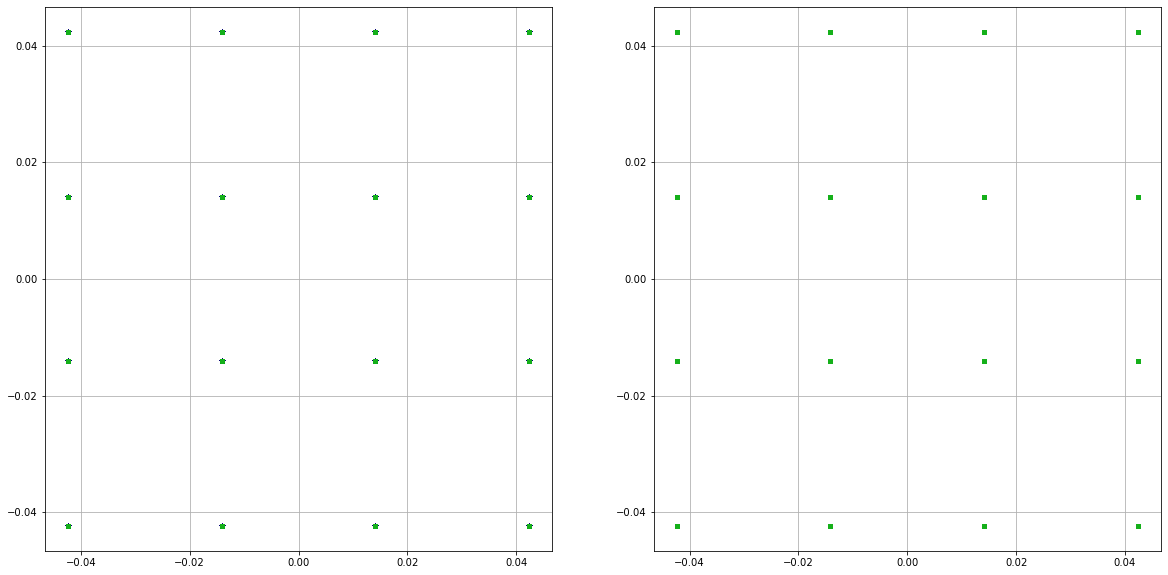

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].scatter(points_x_wo_prop.real, points_x_wo_prop.imag, s=15, c='xkcd:green', marker='o')
axs[0].grid(True)


axs[1].scatter(scale_p * points_x_wo_prop.real, scale_p * points_x_wo_prop.imag, s=15, c='xkcd:green', marker='o')
axs[1].grid(True)

In [464]:
# get processing parameters
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 256 * 4
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024


for key, value in process_parameters.items():
    print(key, value)

z_prop 0
n_symb_proc 16
n_symb_side 1024
n_symb_total 2064
n_symb_skip 1024
n_symb_add 0
window_mode plain
xi_upsampling 1
forward_continuous_type fnft
forward_discrete_type fnft
forward_discrete_coef_type fnftpoly
inverse_type both
fnft_type 0
nft_type bo
use_contour False
n_discrete_skip 10
print_sys_message False
n_steps 1


In [465]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def side_to_np2(n):
    return int(next_power_of_2(n) - n) // 2

In [466]:
side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])

1016

In [467]:
signal_to_process = signal_prop
# signal_to_process = signal_x

process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_add'] = 0
signal_windowed, t_window = prcs.get_windowed_signal(signal_to_process, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

process_parameters['window_mode'] = 'cdc'
# process_parameters['n_symb_add'] = 32
process_parameters['n_symb_add'] = side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal_to_process, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal(signal_x, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)


In [468]:
signal_to_process = signal_to_process.numpy()

In [469]:
# signal_windowed = signal_windowed.numpy()

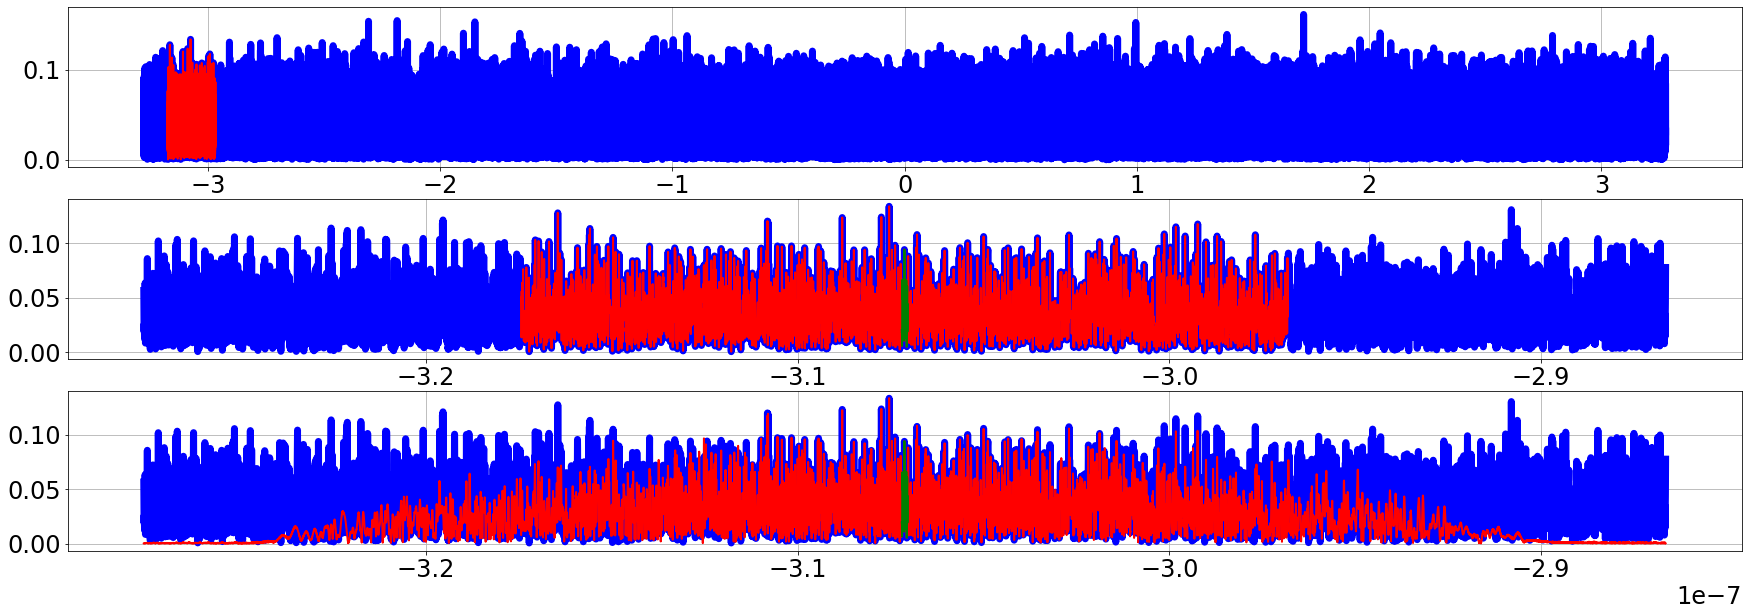

In [470]:
t = (np.arange(len(signal_to_process)) - len(signal_to_process) / 2) / wdm['sample_freq']
plot_shift = 0
range_start = int((process_parameters['n_symb_skip'] - process_parameters['n_symb_add'] - plot_shift) * wdm['upsampling'])
range_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total'] + process_parameters['n_symb_add'] + plot_shift) * wdm['upsampling'])
plot_range = range(range_start, range_end)

range_proc_start = int((process_parameters['n_symb_side'] ) * wdm['upsampling'])
range_proc_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']) * wdm['upsampling'])
plot_range_proc = range(range_proc_start, range_proc_end)

range_proc_window_start = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']) * wdm['upsampling'])
range_proc_window_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc'] + process_parameters['n_symb_add']) * wdm['upsampling'])
plot_range_proc_window = range(range_proc_window_start, range_proc_window_end)

fig, axs = plt.subplots(3, 1, figsize=(30, 10))


axs[0].plot(t, np.absolute(signal_to_process), linewidth=7, color='blue')
axs[0].plot(t_window, np.absolute(signal_windowed), linewidth=2, color='red')
axs[0].grid(True)

axs[1].plot(t[plot_range], np.absolute(signal_to_process[plot_range]), linewidth=7, color='blue')
# processing interval with side intervals
axs[1].plot(t_window, np.absolute(signal_windowed), linewidth=2, color='red')
# processing interval
axs[1].plot(t_window[plot_range_proc], np.absolute(signal_windowed[plot_range_proc]), linewidth=2, color='green')
axs[1].grid(True)

axs[2].plot(t[plot_range], np.absolute(signal_to_process[plot_range]), linewidth=7, color='blue')
# processing interval with side and additional intervals
axs[2].plot(t_window_cdc, np.absolute(signal_windowed_cdc), linewidth=2, color='red')
# processing interval
axs[2].plot(t_window_cdc[plot_range_proc_window], np.absolute(signal_windowed_cdc[plot_range_proc_window]), linewidth=2, color='green')
axs[2].grid(True)

In [471]:
signal_to_process = tf.cast(signal_to_process, tf.complex128)

In [472]:
points_x_process = get_points_wdm(hpcom.signal.matched_filter(signal_to_process, ft_filter_values)[::wdm['downsampling_rate']], wdm)
shift_factor_x_process = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_process)

In [473]:
signal_cdc = dispersion_compensation(channel, signal_prop, 1. / wdm['sample_freq'])

points_x_cdc = get_points_wdm(hpcom.signal.matched_filter(signal_cdc, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_cdc)

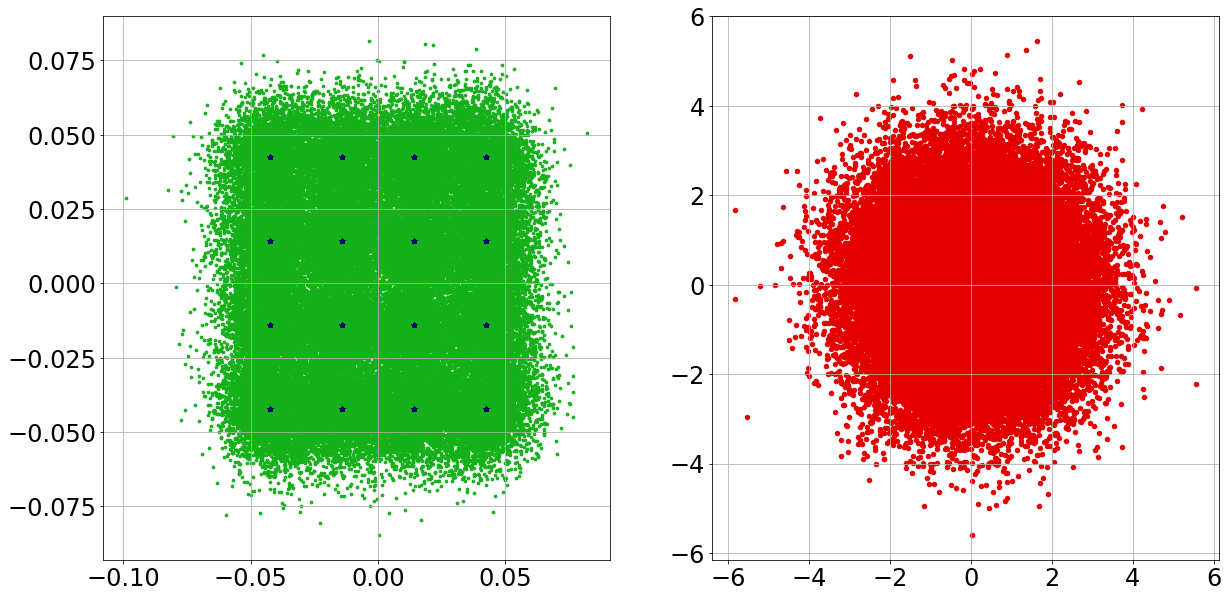

In [474]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_x_cdc_test.real, points_x_cdc_test.imag, s=15, c='xkcd:purple', marker='o')

axs[0].scatter((shift_factor_x * points_x_cdc).real, (shift_factor_x * points_x_cdc).imag, s=30, c='xkcd:green', marker='.')
# axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=30, c='green', marker='x')
axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
# axs[0].scatter(points_x_cdc_test[n_start_test:n_end_test].real, points_x_cdc_test[n_start_test:n_end_test].imag, s=20, c='xkcd:purple', marker='o')
axs[0].grid(True)

# axs[1].scatter(points_y_cdc.real, points_y_cdc.imag, s=6, c='xkcd:green', marker='.')
# axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
# axs[1].scatter(points_y_orig.real, points_y_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].scatter((shift_factor_x_process * points_x_process).real, (points_x_process * shift_factor_x_process).imag, s=20, c='xkcd:red', marker='o')
axs[1].grid(True)

In [475]:
n_signal_total = len(signal_to_process)
signal_windowed_complete = np.concatenate([signal_windowed, np.zeros(n_signal_total - len(signal_windowed))])
signal_windowed_cdc_complete = np.concatenate([signal_windowed_cdc, np.zeros(n_signal_total - len(signal_windowed_cdc))])
print(np.shape(signal_windowed_complete), np.shape(signal_windowed_cdc_complete), n_signal_total)

(262144,) (262144,) 262144


In [476]:
signal_windowed_complete = tf.cast(signal_windowed_complete, tf.complex128)
signal_windowed_cdc_complete = tf.cast(signal_windowed_cdc_complete, tf.complex128)

points_x_window = get_points_wdm(hpcom.signal.matched_filter(signal_windowed_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x_window = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_window)

points_x_window_cdc = get_points_wdm(hpcom.signal.matched_filter(signal_windowed_cdc_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x_window_cdc = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_window_cdc)

In [477]:
print(process_parameters['n_symb_skip'], process_parameters['n_symb_proc'], process_parameters['n_symb_side'], process_parameters['n_symb_add'])
print(wdm['upsampling'])

range_points_start = int((process_parameters['n_symb_side']))
range_points_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']))
range_points = range(range_points_start, range_points_end)

range_points_start_cdc = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']))
range_points_end_cdc = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add'] + process_parameters['n_symb_proc']))
range_points_cdc = range(range_points_start_cdc, range_points_end_cdc)

1024 16 1024 1016
4


In [478]:
range_points_orig_start = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
range_points_orig_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side'] + process_parameters['n_symb_proc']))
range_points_orig = range(range_points_orig_start, range_points_orig_end)

In [479]:
print(np.max(scale_p * points_x_window[range_points] - points_x_orig[range_points_orig]))
print(np.max(scale_p * points_x_window_cdc[range_points_cdc] - points_x_orig[range_points_orig]))


points_found = scale_p * points_x_window[range_points]
points_found_cdc = scale_p * points_x_window_cdc[range_points_cdc]
points_was = points_x_orig[range_points_orig]

table = PrettyTable()
n_rows = 15
n_rows_shift = 0
for k in range(n_rows):
    table.add_row(['{:.5f}'.format(points_was[n_rows_shift + k]),
                   '{:.5f}'.format(points_found[n_rows_shift + k]),
                   '{:.5f}'.format(points_found_cdc[n_rows_shift + k])])

print(table)

(0.09391933822366011+0.0015978047194706926j)
(0.09391939317395337+0.001597701138708399j)
+-------------------+-------------------+-------------------+
|      Field 1      |      Field 2      |      Field 3      |
+-------------------+-------------------+-------------------+
| -0.04238-0.04238j |  0.01506+0.01236j |  0.01506+0.01236j |
|  0.04238-0.04238j |  0.01103-0.01126j |  0.01103-0.01126j |
|  0.01413-0.04238j |  0.05317-0.03086j |  0.05317-0.03086j |
| -0.04238+0.01413j |  0.05154+0.01572j |  0.05154+0.01572j |
| -0.04238-0.01413j |  0.01771-0.01412j |  0.01771-0.01412j |
| -0.01413+0.01413j |  0.00539-0.03844j |  0.00539-0.03844j |
| -0.04238-0.04238j |  0.02248-0.01739j |  0.02248-0.01739j |
|  0.04238+0.01413j | -0.08641-0.02609j | -0.08641-0.02609j |
| -0.01413-0.01413j | -0.00020-0.05795j | -0.00020-0.05795j |
| -0.01413-0.01413j |  0.00954+0.02119j |  0.00954+0.02119j |
| -0.04238+0.01413j |  0.01449+0.02291j |  0.01449+0.02291j |
| -0.04238+0.04238j |  0.02462-0.02761j |  

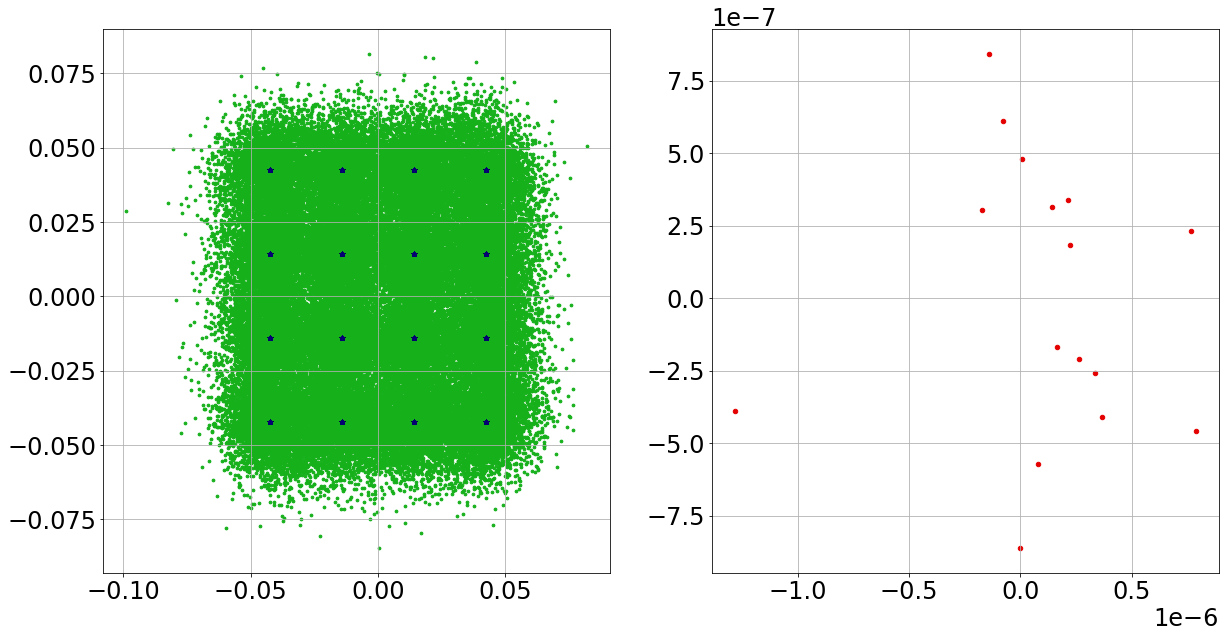

In [480]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_x_cdc_test.real, points_x_cdc_test.imag, s=15, c='xkcd:purple', marker='o')

axs[0].scatter((shift_factor_x * points_x_cdc).real, (shift_factor_x * points_x_cdc).imag, s=30, c='xkcd:green', marker='.')
# axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=30, c='green', marker='x')
axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
# axs[0].scatter(points_x_cdc_test[n_start_test:n_end_test].real, points_x_cdc_test[n_start_test:n_end_test].imag, s=20, c='xkcd:purple', marker='o')
axs[0].grid(True)

# axs[1].scatter(points_y_cdc.real, points_y_cdc.imag, s=6, c='xkcd:green', marker='.')
# axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
# axs[1].scatter(points_y_orig.real, points_y_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].scatter((points_x_window[range_points]).real, (points_x_window[range_points]).imag, s=20, c='xkcd:red', marker='o')
axs[1].grid(True)

In [481]:
import FNFTpy as fpy
import PJTpy as pjt

In [482]:
print(fpy.get_lib_path())
print(pjt.get_lib_path())

/home/esf0/lib/FNFT_extended_manakov/FNFT_extended/lib/libfnft.so.0.4.1
/home/esf0/lib/PJT_to_Huawei/pjt/lib/libpjt.so.0.1.0


Transform signal to dimensionless domain

In [483]:
# signal_windowed_cdc, t_window_cdc
# signal_windowed, t_window

convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                 channel['beta2'],
                                 channel['gamma'],
                                 t0=1. / wdm['symb_freq'], type='nlse')

q_windowed_cdc = convert_result['q']
t_dl_window_cdc = convert_result['t']
dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
z_span_dimless = convert_result['z']
z_dimless = z_span_dimless * channel['n_spans']

In [484]:
n_t = len(t_dl_window_cdc)
t_span = t[-1] - t[0]
# print(t_span, dt * (n_t - 1))
xi_upsampling = 4
n_xi = xi_upsampling * n_t

fnft_type=11

t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2


rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)


start_time = datetime.now()
result_nlse = fpy.nsev(q_windowed_cdc, t_for_nft, xi[0], xi[-1], n_xi, dst=2, cst=2, dis=fnft_type, K=2048, display_c_msg=True)
print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")


forward NFT took 37883.820999999996 ms


In [485]:
start_time = datetime.now()
result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
# result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")


PJT took 47620.717 ms


In [486]:
print(len(result_nlse['bound_states']), len(result_pjt['bound_states']))

745 1044


In [487]:
# print(result_nlse['bound_states'])
print(result_nlse)
bs_nlse = result_nlse['bound_states']

print(result_pjt['bound_states'])
print(result_pjt)
bs_pjt = result_pjt['bound_states']

{'return_value': 0, 'bound_states_num': 745, 'bound_states': array([ 1.09045094+0.0054532j ,  1.09421928+0.02124811j,
        1.0947109 +0.00339249j,  1.09750476+0.00779527j,
        1.10703023+0.00987494j,  1.11638742+0.01981616j,
        1.10846321+0.00596161j,  1.11265973+0.00970297j,
        1.11093722+0.0074125j ,  1.11770193+0.00947537j,
        1.12433045+0.00259054j,  1.12179879+0.01442948j,
        1.12784236+0.00276864j,  1.1341907 +0.01529404j,
        1.1371803 +0.00595443j,  1.13866615+0.00459444j,
        1.1386657 +0.0045943j ,  1.14338742+0.00958763j,
        1.15045464+0.0058712j ,  1.16214054+0.01171727j,
        1.15740262+0.01399991j,  1.1633823 +0.0107735j ,
        1.16616771+0.01600555j,  1.17988824+0.01216808j,
        1.17742146+0.00506801j,  1.17742414+0.00506684j,
        1.18269482+0.00547464j,  1.1799067 +0.01199333j,
        1.18547773+0.01234236j,  1.19038354+0.01002473j,
        1.19140292+0.0017647j ,  1.19108923+0.00955395j,
        1.22149803+0.041476

In [488]:
bs_nlse_sort = bs_nlse[np.argsort(np.abs(bs_nlse))]
bs_pjt_sort = bs_pjt[np.argsort(np.abs(bs_pjt))]

table = PrettyTable()
n_rows = 43
n_rows_shift = 0
for k in range(n_rows):
    table.add_row(['{:.5f}'.format(bs_nlse_sort[n_rows_shift + k]),
                   '{:.5f}'.format(bs_pjt_sort[n_rows_shift + k])])

print(table)

+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
|  0.00353+0.00474j | -0.00105+0.00023j |
|  0.00369+0.00597j |  0.00157+0.00308j |
| -0.00996+0.00514j |  0.00212+0.00643j |
|  0.01351+0.00915j | -0.00660+0.00351j |
| -0.01505+0.00835j |  0.00537+0.00700j |
| -0.01777+0.00509j | -0.00997+0.00514j |
|  0.02616+0.00752j |  0.01102+0.00698j |
| -0.02651+0.00728j |  0.01377+0.00119j |
| -0.03367+0.00325j | -0.01309+0.00934j |
| -0.03940+0.00501j |  0.01355+0.00915j |
| -0.03941+0.00501j |  0.01780+0.00107j |
| -0.03945+0.00767j | -0.01752+0.00483j |
|  0.03954+0.00861j |  0.02155+0.00206j |
|  0.03953+0.00866j | -0.02143+0.00406j |
|  0.03972+0.00973j | -0.02405+0.00095j |
|  0.04096+0.00683j |  0.02481+0.00371j |
| -0.04038+0.01004j |  0.02614+0.00752j |
| -0.04042+0.01000j | -0.02651+0.00728j |
|  0.04177+0.00962j |  0.02773+0.00094j |
|  0.04441+0.01099j | -0.03260+0.00436j |
|  0.04441+0.01099j | -0.03352+0.0

In [489]:
a = result_nlse['cont_a']
b = result_nlse['cont_b']
r = result_nlse['cont_ref']

res = result_pjt

rd = res['disc_res']
bd = res['disc_norm']
xi_d = res['bound_states']
# ad = bd / rd

b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))

start_time = datetime.now()
result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop, cst=1, dst=0)
print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

q_fnft = result_nsev_inverse['q']

FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 60496.055 ms


In [490]:
convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='nlse')

signal_nft = convert_forward_result['Q']
t_nft = convert_forward_result['T']

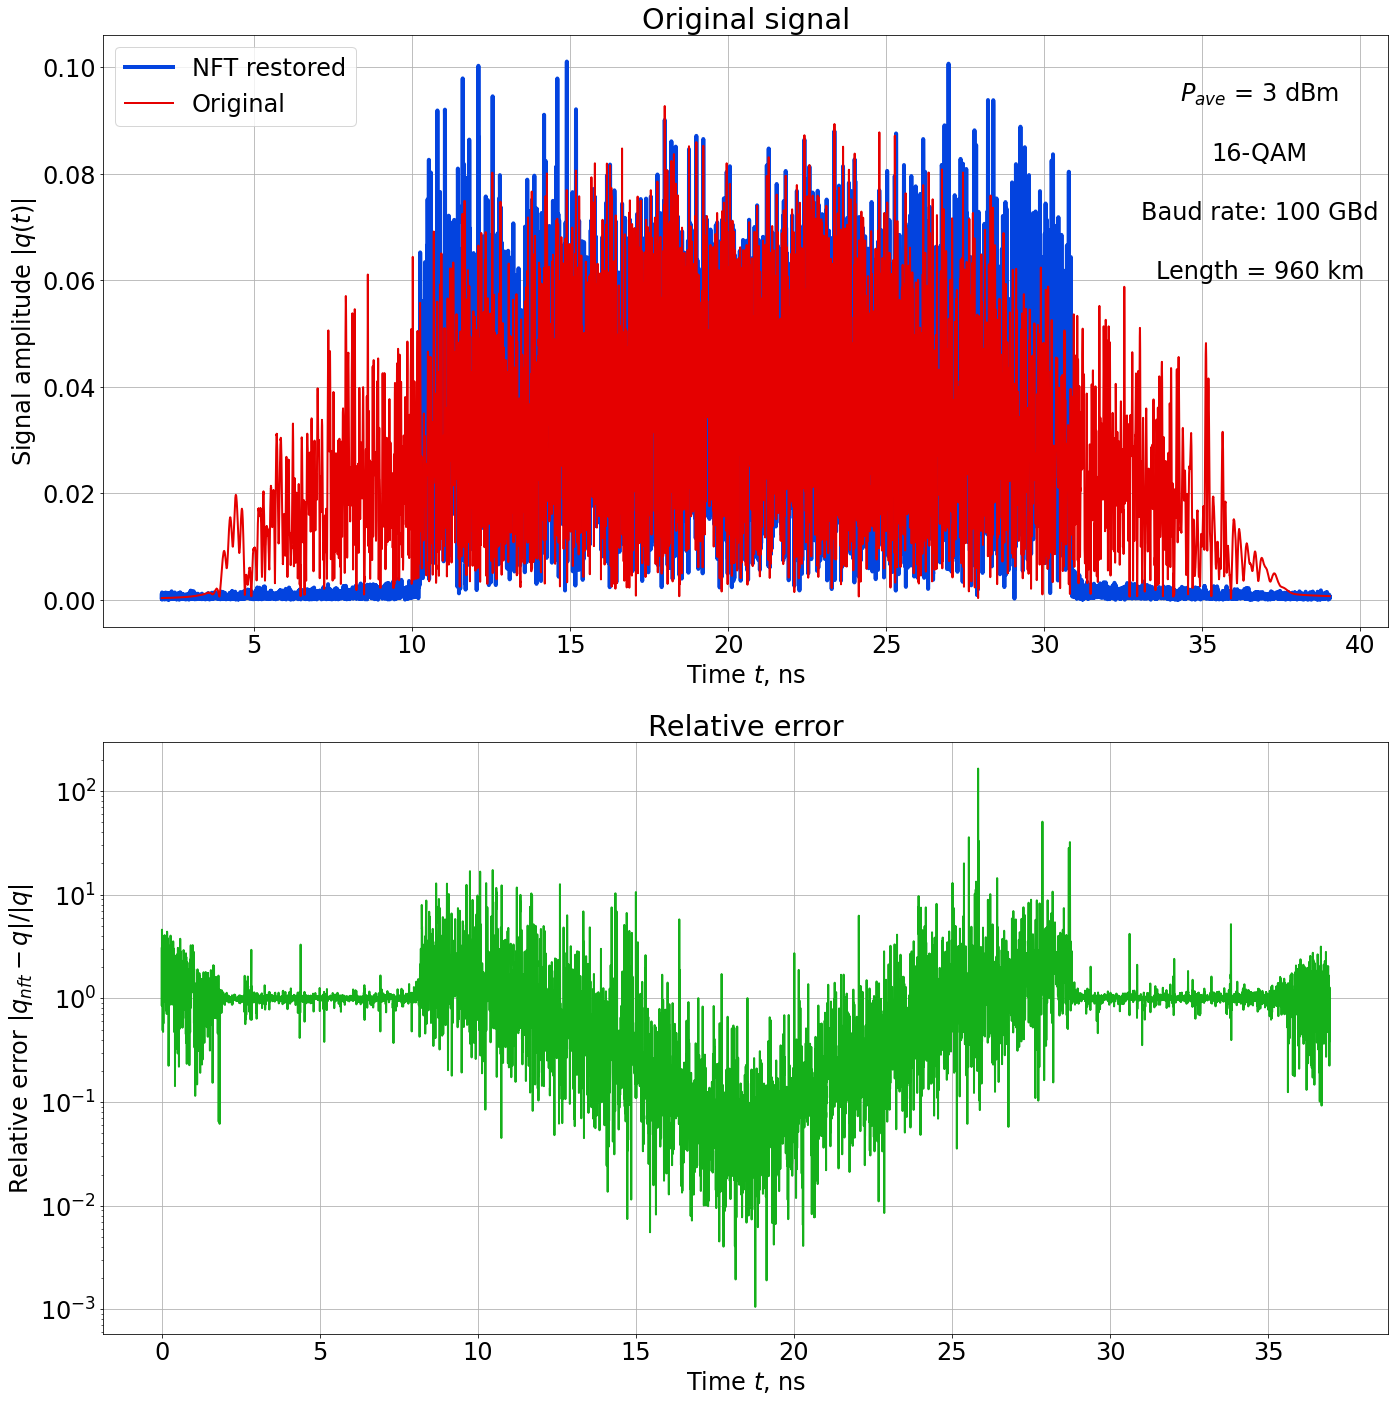

In [491]:
from matplotlib.gridspec import GridSpec
matplotlib.rcParams.update({'font.size': 24})

# gs = GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1])
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 1])

fig = plt.figure(figsize=(20, 20))

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[2])

stp = len(t_nft) // 2 - 250
plot_range = range(stp, stp+500)
plot_range = range(800, len(t_nft)-800)

scale_for_time = 1e9

ax1.plot((t_nft[plot_range] - t[0])* scale_for_time, np.absolute(signal_nft[plot_range]), linewidth=4, color='xkcd:blue', label='NFT restored')
ax1.plot((t_tx_window_cdc[plot_range] - t[0])* scale_for_time, np.absolute(signal_tx_windowed_cdc[plot_range]), linewidth=2, color='xkcd:red', label='Original')
ax1.set_title(r'Original signal')
ax1.set_ylabel(r'Signal amplitude $|q(t)|$')
ax1.set_xlabel(r'Time $t$, ns')
ax1.grid(True)
ax1.legend(loc='upper left')
# ax1.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))
# ax1.set_xlim(t_tx_window_cdc[plot_range][0], t_tx_window_cdc[plot_range][-1])

ax1.text(0.9, 0.9, r'$P_{ave}$ = ' + str(wdm['p_ave_dbm']) + ' dBm',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.8, str(wdm['m_order']) + '-QAM',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.7, 'Baud rate: ' + str(int(wdm['symb_freq'] / 1e9)) + ' GBd',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.6, 'Length = ' + str(int(channel['n_spans'] * channel['z_span'])) + ' km',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)


ax2.plot((t_tx_window_cdc[plot_range] - t_tx_window_cdc[plot_range][0]) * scale_for_time, (np.absolute(signal_tx_windowed_cdc-signal_nft)/np.absolute(signal_tx_windowed_cdc))[plot_range], linewidth=2, color='xkcd:green')
ax2.set_title(r'Relative error')
ax2.set_ylabel(r'Relative error $|q_{nft} - q|/|q|$')
ax2.set_xlabel(r'Time $t$, ns')
ax2.set_yscale('log')
ax2.grid(True)
# ax2.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))
# ax2.set_xlim(t_nft[plot_range][0], t_nft[plot_range][-1])


# ax3.plot(t_dl_window_cdc, np.absolute(q_windowed_cdc), linewidth=2, color='green')
# ax3.grid(True)

plt.tight_layout()

fig.savefig('images/' + 'nft_restoration_and_relative_error' + name_set + '.pdf', format='pdf', bbox_inches='tight')
fig.savefig('images/' + 'nft_restoration_and_relative_error' + name_set + '.png', format='png', bbox_inches='tight')


Decode points


In [492]:
# add zeros to the end of the signal to process with the same length as the original signal
n_signal_total = len(signal_to_process)
signal_nft_complete = np.concatenate(
    [signal_nft, np.zeros(n_signal_total - len(signal_nft))])
signal_nft_complete = tf.cast(signal_nft_complete, tf.complex128)


points_x_nft = get_points_wdm(
    hpcom.signal.matched_filter(signal_nft_complete, ft_filter_values)[::wdm['downsampling_rate']],
    wdm)
# shift_factor_x_window_cdc = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(
#     np.transpose(np.conjugate(points_x_orig)), points_x_window_cdc)

print(process_parameters['n_symb_skip'], process_parameters['n_symb_proc'], process_parameters['n_symb_side'],
      process_parameters['n_symb_add'])

range_points_start_cdc = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']))
range_points_end_cdc = int(
    (process_parameters['n_symb_side'] + process_parameters['n_symb_add'] + process_parameters['n_symb_proc']))
range_points_cdc = range(range_points_start_cdc, range_points_end_cdc)


range_points_orig_start = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
range_points_orig_end = int(
    (process_parameters['n_symb_skip'] + process_parameters['n_symb_side'] + process_parameters['n_symb_proc']))
range_points_orig = range(range_points_orig_start, range_points_orig_end)

# points_found = scale_p * points_x_window[range_points]
points_found_nft = points_x_nft[range_points_cdc]
points_was = points_x_orig[range_points_orig]

shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_was)), points_was) / np.dot(
    np.transpose(np.conjugate(points_was)), points_found_nft)

# points_found_nft *= scale_p
points_found_nft *= shift_factor_x_nft

# print(np.max(scale_p * points_x_window[range_points] - points_x_orig[range_points_orig]))
print(np.max(np.absolute(points_found_nft - points_was)), np.max(np.absolute(points_found_nft - points_was)) / np.mean(np.absolute(points_was)))

table = PrettyTable()
n_rows = 15
n_rows_shift = 0
for k in range(n_rows):
    table.add_row(['{:.5f}'.format(points_was[n_rows_shift + k]),
                   '{:.5f}'.format(points_found_nft[n_rows_shift + k])])

print(table)

1024 16 1024 1016
0.0027114218703264597 0.06912665673485073
+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
| -0.04238-0.04238j | -0.04104-0.04285j |
|  0.04238-0.04238j |  0.04118-0.04291j |
|  0.01413-0.04238j |  0.01506-0.04366j |
| -0.04238+0.01413j | -0.04348+0.01467j |
| -0.04238-0.01413j | -0.04155-0.01240j |
| -0.01413+0.01413j | -0.01639+0.01263j |
| -0.04238-0.04238j | -0.04164-0.04148j |
|  0.04238+0.01413j |  0.04140+0.01464j |
| -0.01413-0.01413j | -0.01382-0.01497j |
| -0.01413-0.01413j | -0.01450-0.01549j |
| -0.04238+0.01413j | -0.04177+0.01549j |
| -0.04238+0.04238j | -0.04251+0.04200j |
| -0.01413+0.01413j | -0.01261+0.01576j |
| -0.01413-0.01413j | -0.01480-0.01590j |
|  0.01413+0.04238j |  0.01447+0.04294j |
+-------------------+-------------------+


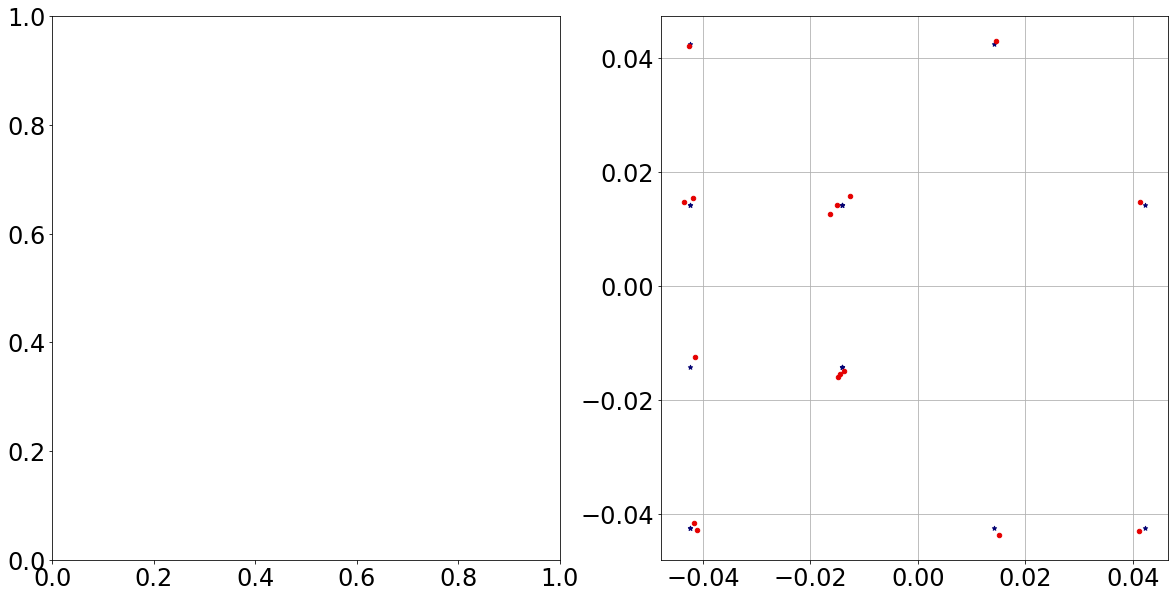

In [493]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_x_cdc_test.real, points_x_cdc_test.imag, s=15, c='xkcd:purple', marker='o')

# axs[0].scatter((shift_factor_x * points_x_cdc).real, (shift_factor_x * points_x_cdc).imag, s=30, c='xkcd:green', marker='.')
# # axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=30, c='green', marker='x')
# axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
# # axs[0].scatter(points_x_cdc_test[n_start_test:n_end_test].real, points_x_cdc_test[n_start_test:n_end_test].imag, s=20, c='xkcd:purple', marker='o')
# axs[0].grid(True)

# axs[1].scatter(points_y_cdc.real, points_y_cdc.imag, s=6, c='xkcd:green', marker='.')
# axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
axs[1].scatter(points_was.real, points_was.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].scatter((points_found_nft).real, (points_found_nft).imag, s=20, c='xkcd:red', marker='o')
axs[1].grid(True)

In [494]:
import sys
print(sys.executable)
import importlib
import os
# Replace 'package_name' with the actual name of the package you want to locate
package_name = 'FNFTpy'

# Import the package
pkg = importlib.import_module(package_name)

# Get the package location
package_location = os.path.dirname(os.path.abspath(pkg.__file__))

# Print the package location
print(f"{package_name} is located at: {package_location}")

/home/esf0/anaconda3/envs/nn_env/bin/python
FNFTpy is located at: /home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/FNFTpy


In [495]:
# t_window_cdc, np.absolute(signal_windowed_cdc)

In [496]:
result = pjt.pjt(signal_windowed_cdc, t_window_cdc, contSpec=None, omp_num_threads=4, display_c_msg=True)

In [497]:
signal_to_process = signal_to_process.numpy()

In [498]:

plot_shift = 0
range_start = int((process_parameters['n_symb_skip'] - process_parameters['n_symb_add'] - plot_shift) * wdm['upsampling'])
range_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total'] + process_parameters['n_symb_add'] + plot_shift) * wdm['upsampling'])
plot_range = range(range_start, range_end)

range_proc_start = int((process_parameters['n_symb_side'] ) * wdm['upsampling'])
range_proc_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']) * wdm['upsampling'])
plot_range_proc = range(range_proc_start, range_proc_end)

range_proc_window_start = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']) * wdm['upsampling'])
range_proc_window_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc'] + process_parameters['n_symb_add']) * wdm['upsampling'])
plot_range_proc_window = range(range_proc_window_start, range_proc_window_end)

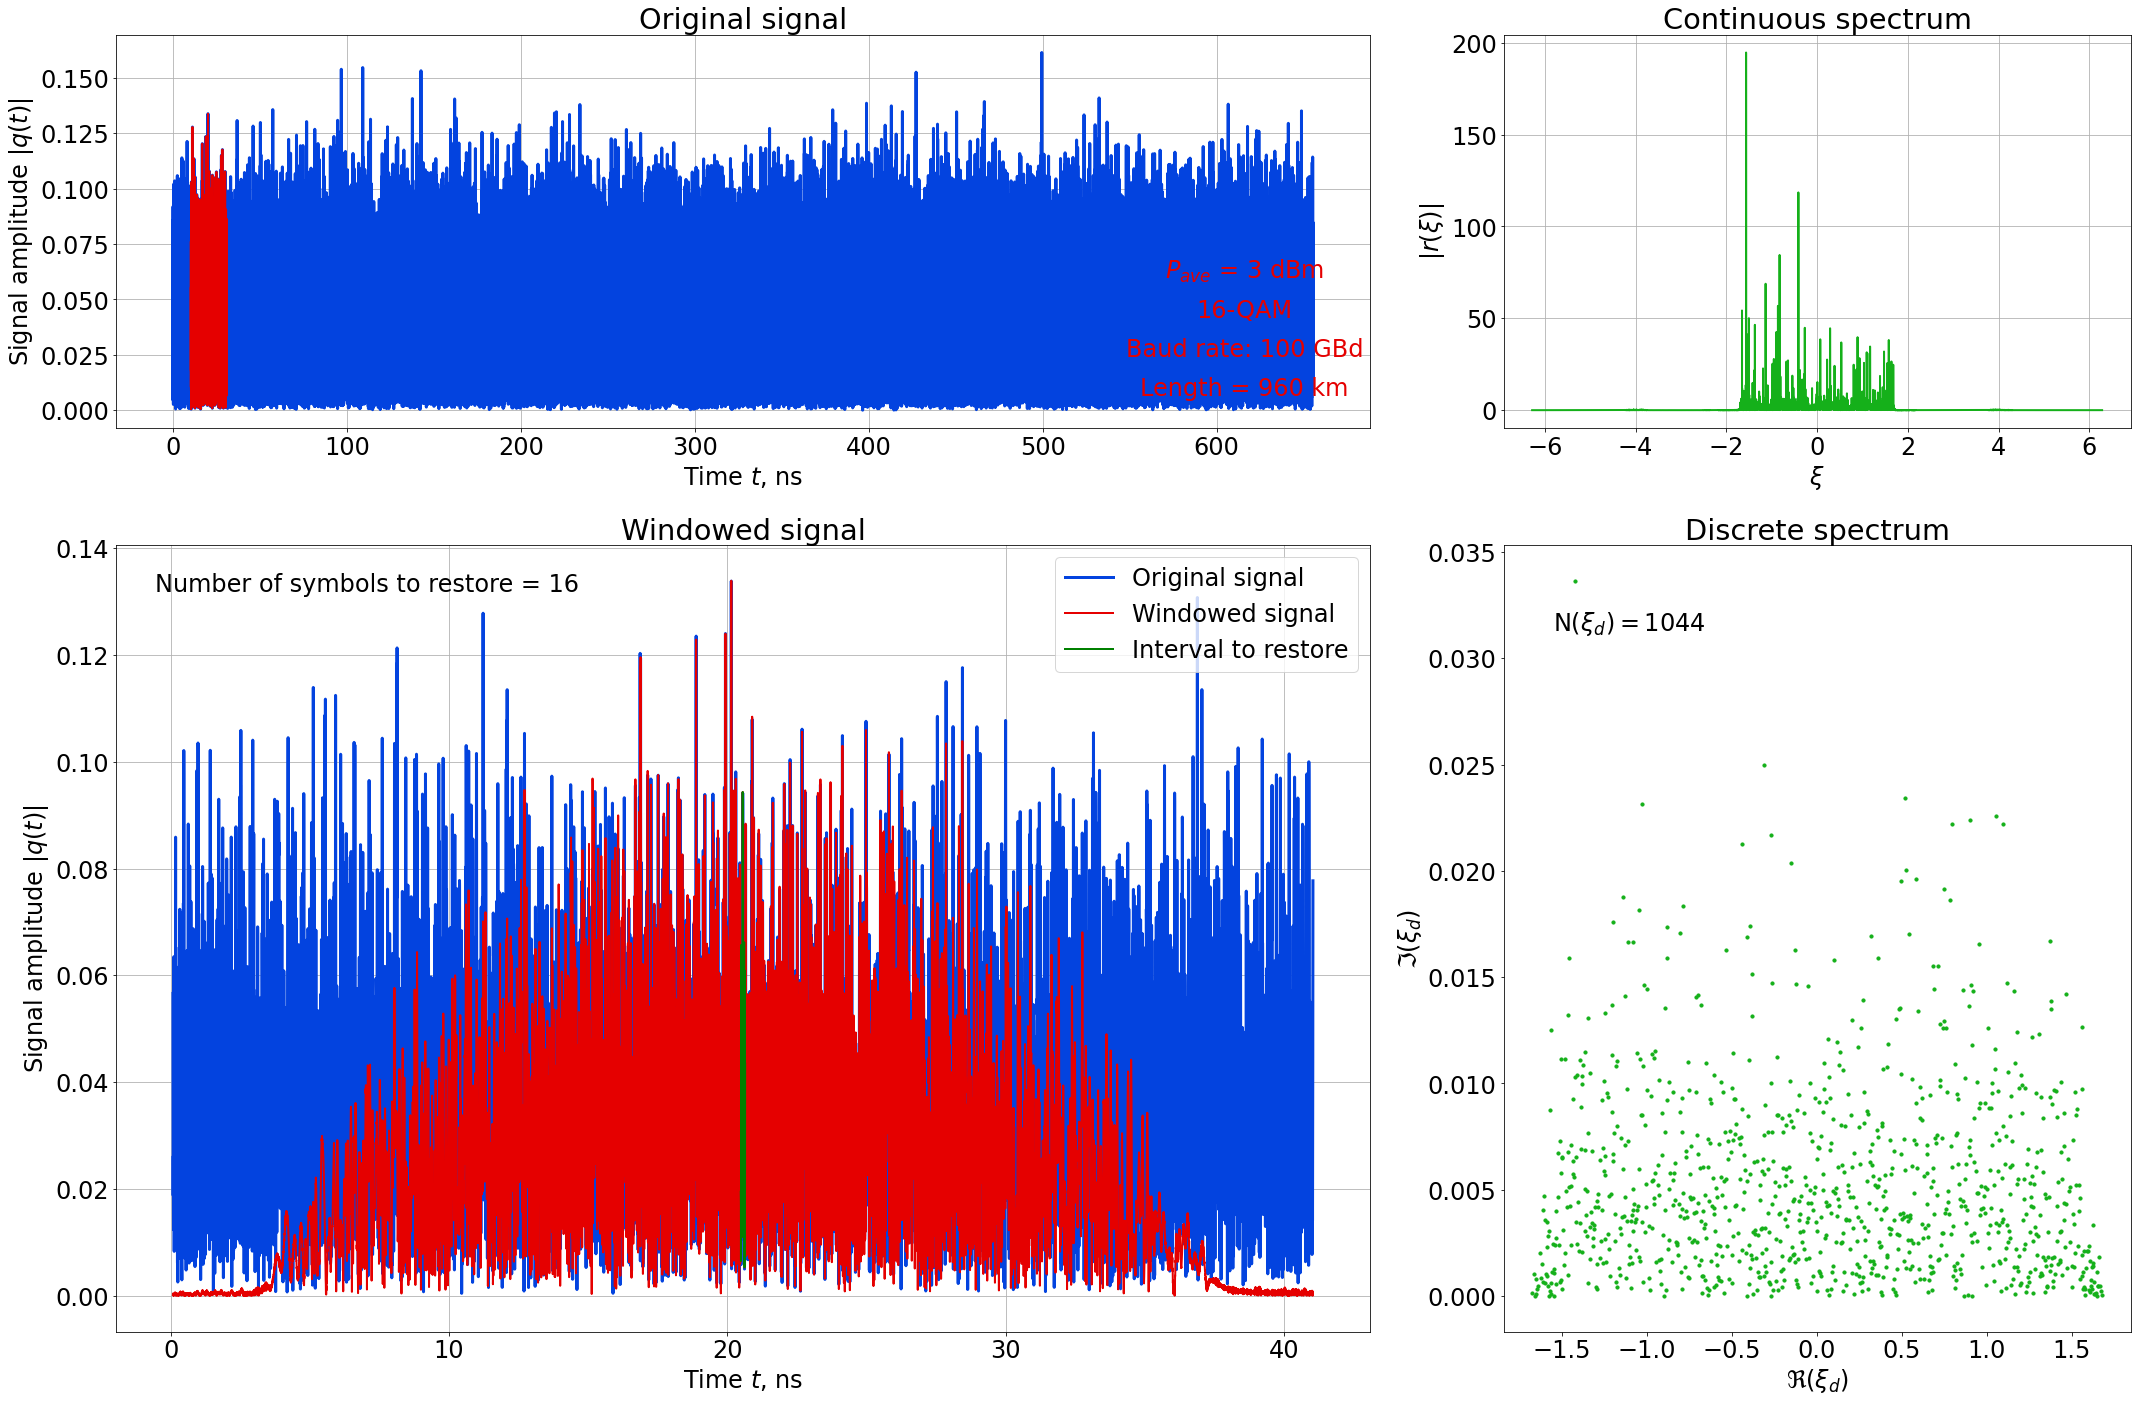

In [499]:
from matplotlib.gridspec import GridSpec
matplotlib.rcParams.update({'font.size': 24})

gs = GridSpec(nrows=2, ncols=2, width_ratios=[2, 1], height_ratios=[1, 2])

fig = plt.figure(figsize=(30, 20))

# Create the subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

scale_for_time = 1e9

ax1.plot((t - t[0]) * scale_for_time, np.absolute(signal_to_process), linewidth=3, color='xkcd:blue', label='Original signal')
ax1.plot((t_window - t[0]) * scale_for_time, np.absolute(signal_windowed), linewidth=2, color='xkcd:red', label='Windowed signal')
ax1.set_title(r'Original signal')
ax1.set_ylabel(r'Signal amplitude $|q(t)|$')
ax1.set_xlabel(r'Time $t$, ns')
ax1.grid(True)
ax1.text(0.9, 0.4, r'$P_{ave}$ = ' + str(wdm['p_ave_dbm']) + ' dBm',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24,
         color='xkcd:red')
ax1.text(0.9, 0.3, str(wdm['m_order']) + '-QAM',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24,
         color='xkcd:red')
ax1.text(0.9, 0.2, 'Baud rate: ' + str(int(wdm['symb_freq'] / 1e9)) + ' GBd',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24,
         color='xkcd:red')
ax1.text(0.9, 0.1, 'Length = ' + str(int(channel['n_spans'] * channel['z_span'])) + ' km',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24,
         color='xkcd:red')

# ax1.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))

# ax2.plot(t[plot_range], np.absolute(signal_to_process[plot_range]), linewidth=7, color='blue')
# # processing interval with side intervals
# ax2.plot(t_window, np.absolute(signal_windowed), linewidth=2, color='red')
# # processing interval
# ax2.plot(t_window[plot_range_proc], np.absolute(signal_windowed[plot_range_proc]), linewidth=2, color='green')
ax2.plot(xi, np.absolute(result_nlse['cont_b']/result_nlse['cont_a']), linewidth=2, color='xkcd:green')
ax2.set_title(r'Continuous spectrum')
ax2.set_ylabel(r'$|r(\xi)|$')
ax2.set_xlabel(r'$\xi$')
ax2.grid(True)


# t * 1000 -> ns into ps
ax3.plot((t[plot_range] - t[0]) * scale_for_time, np.absolute(signal_to_process[plot_range]), linewidth=3, color='xkcd:blue', label='Original signal')
# ax3.plot(t, np.absolute(signal_to_process), linewidth=3, color='blue')
# processing interval with side and additional intervals
ax3.plot((t_window_cdc - t[0]) * scale_for_time, np.absolute(signal_windowed_cdc), linewidth=2, color='xkcd:red', label='Windowed signal')
# processing interval
ax3.plot((t_window_cdc[plot_range_proc_window] - t[0]) * scale_for_time, np.absolute(signal_windowed_cdc[plot_range_proc_window]), linewidth=2, color='green',
         label='Interval to restore')
ax3.set_title(r'Windowed signal')
ax3.set_ylabel(r'Signal amplitude $|q(t)|$')
ax3.set_xlabel(r'Time $t$, ns')
ax3.grid(True)
ax3.legend(loc='upper right')
ax3.text(0.2, 0.95, r'Number of symbols to restore = ' + str(process_parameters['n_symb_proc']),
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax3.transAxes, fontsize=24)
# ax3.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))
# ax3.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax4.scatter(np.real(result_pjt['bound_states']), np.imag(result_pjt['bound_states']), c='xkcd:green', marker='.', s=40)
ax4.set_title(r'Discrete spectrum')
ax4.set_ylabel(r'$\Im(\xi_d)$')
ax4.set_xlabel(r'$\Re(\xi_d)$')
ax4.text(0.2, 0.9, r'N($\xi_d) = $' + str(len(result_pjt['bound_states'])), horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()

fig.savefig('images/' + 'signal_and_nf_spectrum' + name_set + '.pdf', format='pdf', bbox_inches='tight')
fig.savefig('images/' + 'signal_and_nf_spectrum' + name_set + '.png', format='png', bbox_inches='tight')
